In [102]:
import numpy as np
import pandas as pd
import material as ml
import thinfilm as tm
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize

In [103]:
# 0, 1, 2, 3, 4, 5
wl = lambda x: np.linspace(400, 700, 301)[x*50:x*50+51]
wl_all =np.linspace(400, 700, 301)
R_scan = pd.read_csv('./spectrum/LENS/rev1/R_5_B.csv')['SCAN'].values

air = ml.Non_Dispersion(1)
SiO2 = ml.open_material('SiO2_LENS', 'Sellmeier') 
SiN = ml.open_material('SiN_LENS', 'Sellmeier')
OC = ml.open_material('OC_LENS', 'Material')
sodalime = ml.open_material('sodalime', 'Material')

# th[2] 波段 I~IV
def R_hypo(th):
    ITO0 = ml.Chromatic_Dispersion(th[6], th[7], np.median(wl(0)))
    ITO1 = ml.Chromatic_Dispersion(th[8], th[9], np.median(wl(1)))
    ITO2 = ml.Chromatic_Dispersion(th[10], th[11], np.median(wl(2)))
    ITO3 = ml.Chromatic_Dispersion(th[12], th[13], np.median(wl(3)))
    ITO4 = ml.Chromatic_Dispersion(th[14], th[15], np.median(wl(4)))
    ITO5 = ml.Chromatic_Dispersion(th[16], th[17], np.median(wl(5)))
    #
    R_hypo0 = tm.Design(
        [air, OC, SiN, SiO2, ITO0, SiO2, SiN, sodalime],
        [None, th[0], th[1], th[2], th[3], th[4], th[5], None]
    ).reflectance(wl(0), 5)
    
    R_hypo1 = tm.Design(
        [air, OC, SiN, SiO2, ITO1, SiO2, SiN, sodalime],
        [None, th[0], th[1], th[2], th[3], th[4], th[5], None]
    ).reflectance(wl(1), 5)
    
    R_hypo2 = tm.Design(
        [air, OC, SiN, SiO2, ITO2, SiO2, SiN, sodalime],
        [None, th[0], th[1], th[2], th[3], th[4], th[5], None]
    ).reflectance(wl(2), 5)
    
    R_hypo3 = tm.Design(
        [air, OC, SiN, SiO2, ITO3, SiO2, SiN, sodalime],
        [None, th[0], th[1], th[2], th[3], th[4], th[5], None]
    ).reflectance(wl(3), 5)
    
    R_hypo4 = tm.Design(
        [air, OC, SiN, SiO2, ITO4, SiO2, SiN, sodalime],
        [None, th[0], th[1], th[2], th[3], th[4], th[5], None]
    ).reflectance(wl(4), 5)
                        
    R_hypo5 = tm.Design(
        [air, OC, SiN, SiO2, ITO5, SiO2, SiN, sodalime],
        [None, th[0], th[1], th[2], th[3], th[4], th[5], None]
    ).reflectance(wl(5), 5)
    return np.concatenate(
        (
            R_hypo0[:-1],
            R_hypo1[:-1],
            R_hypo2[:-1],
            R_hypo3[:-1],
            R_hypo4[:-1],
            R_hypo5
    )
)

def exam(a1, a2, a3, a4, a5, a6):
    H1 = sum([a1 < i for i in [a2, a3, a4, a5, a6]])
    H2 = sum([a2 < i for i in [a3, a4, a5, a6]])
    H3 = sum([a3 < i for i in [a4, a5, a6]])
    H4 = sum([a4 < i for i in [a5, a6]])
    H5 = sum([a5 < i for i in [a6]])
    return -(H1+H2+H3+H4+H5)

SEM = lambda th: abs(th[1]+th[2]-59.5)+abs(th[4]+th[5]-53.6)

FOM = lambda th: 10*np.mean(
    abs(100*R_hypo(th)-R_scan)
) + exam(
    th[7],th[9],th[11],th[13],th[15],th[17],
) + exam(
    th[16],th[14],th[12],th[10],th[8],th[6],
) + SEM(th)

In [104]:
sol = differential_evolution(
    FOM, [
        (2100,2300), # O.C
        (5,20), # T SiN
        (30,55), # T SiO2
        (26,30), # ITO
        (30,55), # B SiN
        (5,20), # B SiO2
        (1.854,1.957), (-3, -0.02), # I
        (1.754,1.90), (-3, -0.02), # II
        (1.754,1.857), (-2, -0.02), # III
        (1.754,1.857), (-1, -0.02), # IV
        (1.744,1.777), (-1, -0.02), # V
        (1.744,1.777), (-1, -0.02), # VI
    ], disp = True, polish = False, popsize = 10, mutation = 0.3, recombination = 0.9
)
print(sol.x)

differential_evolution step 1: f(x)= -20.6409
differential_evolution step 2: f(x)= -23.179
differential_evolution step 3: f(x)= -23.652
differential_evolution step 4: f(x)= -23.7337
differential_evolution step 5: f(x)= -23.9629
differential_evolution step 6: f(x)= -23.9994
differential_evolution step 7: f(x)= -24.0698
differential_evolution step 8: f(x)= -24.1024
[ 2.13049090e+03  1.21044835e+01  4.73969028e+01  2.61592590e+01
  4.69229178e+01  6.67267587e+00  1.91049644e+00 -1.82822698e+00
  1.87839264e+00 -1.81139016e+00  1.85561282e+00 -1.11378335e+00
  1.78120399e+00 -7.04707880e-01  1.77630663e+00 -4.54164288e-01
  1.76354452e+00 -4.01004550e-01]


In [1]:
res = sol.x
plt.plot(wl_all, 100*R_hypo(res), '--k')
plt.plot(wl_all, R_scan, '-k')
plt.show()

NameError: name 'sol' is not defined

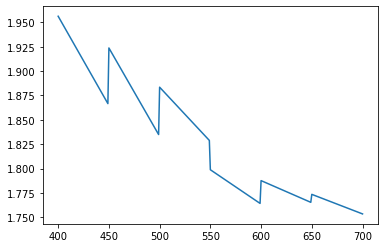

In [108]:
tk = [2.27734075e+03,
      1.74885157e+01,
      3.02346676e+01,
      2.99984589e+01,
      2.49660010e+01,
      3.00304178e+01,
      1.95564115e+00,-3.40570251e+00,
      1.86441704e+00,-1.27622826e+00,
      1.81433093e+00,-1.08490127e+00,
      1.77926182e+00,-9.10104851e-01,
      1.75321443e+00,-5.17712510e-01,
      1.74595725e+00,-2.36503140e-01,
]


th = sol.x
ITO0 = ml.Chromatic_Dispersion(th[6], th[7], np.median(wl(0)))
ITO1 = ml.Chromatic_Dispersion(th[8], th[9], np.median(wl(1)))
ITO2 = ml.Chromatic_Dispersion(th[10], th[11], np.median(wl(2)))
ITO3 = ml.Chromatic_Dispersion(th[12], th[13], np.median(wl(3)))
ITO4 = ml.Chromatic_Dispersion(th[14], th[15], np.median(wl(4)))
ITO5 = ml.Chromatic_Dispersion(th[16], th[17], np.median(wl(5)))

ITO_n = np.concatenate(
        (
            ITO0.nvalues(wl(0))[:-1],
            ITO1.nvalues(wl(1))[:-1],
            ITO2.nvalues(wl(2))[:-1],
            ITO3.nvalues(wl(3))[:-1],
            ITO4.nvalues(wl(4))[:-1],
            ITO5.nvalues(wl(5))
    )
)


plt.plot(wl_all, ITO_n)
plt.show()